# Homework 2: EA for constrained optimizations #

Name: Filip Špidla

Mail: spidlfil@cvut.fel.cz

## Problem definitions ##

In [303]:
import re
import numpy as np
import random

np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [304]:
import numpy as np
import re

def load_problem_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    objective = None
    constraints = {}
    num_vars = 0

    var_pattern = re.compile(r'x\d+')

    for line in lines:
        line = line.strip()

        vars_in_line = var_pattern.findall(line)
        num_vars = max(num_vars, len(set(vars_in_line)))

        if line.startswith('f('):
            _, expression = line.split('=', 1)
            def objective(*args, expr=expression):
                local_vars = {f'x{i+1}': arg for i, arg in enumerate(args)}
                return eval(expr, {"__builtins__": {"np": np}}, local_vars)
        elif line.startswith('g'):
            constraint_name, expression = line.split('=', 1)
            def constraint(*args, expr=expression):
                local_vars = {f'x{i+1}': arg for i, arg in enumerate(args)}
                global_vars = {"abs": abs, "np": np}  # Include 'abs' in the global context
                return eval("0 if " + expr + " else 1", global_vars, local_vars)
            constraints[constraint_name] = constraint

    return objective, constraints, num_vars


## Two approaches ##

### Stochastic Ranking ###

In [305]:
def stochastic_ranking(population, fitness_function, constraints_wrapper, num_generations, gene_bounds, pf=0.45):
    generation = 0

    # Evaluate initial population
    for individual in population:
        individual.fitness = fitness_function(individual.genes)
        individual.constraint_violation = sum(max(0, violation) for violation in constraints_wrapper(individual.genes))

    while generation < num_generations:
        # Creating the next generation
        new_population = []
        while len(new_population) < len(population):
            parent1 = tournament_select(population)
            parent2 = tournament_select(population)
            child1, child2 = crossover(parent1, parent2, gene_bounds)
            new_population.extend([mutate(child1, 0.2, gene_bounds), mutate(child2, 0.2, gene_bounds)])

        # Evaluate new population
        for individual in new_population:
            individual.fitness = fitness_function(individual.genes)
            individual.constraint_violation = sum(max(0, violation) for violation in constraints_wrapper(individual.genes))

        # Combine and apply stochastic ranking
        combined_population = population + new_population
        ranked_population = stochastic_rank(combined_population, pf)

        # Select the next generation
        population = ranked_population[:len(population)]
        #print(f"Generation {generation} completed.")
        generation += 1

    return population

def stochastic_rank(population, pf):
    n = len(population)
    for _ in range(n):
        i = random.randint(0, n-1)
        j = random.randint(0, n-1)
        if (population[i].constraint_violation == 0 and population[j].constraint_violation == 0) or \
           (random.random() < pf):
            if population[i].fitness < population[j].fitness:
                population[i], population[j] = population[j], population[i]
        else:
            if population[i].constraint_violation > population[j].constraint_violation:
                population[i], population[j] = population[j], population[i]

    return sorted(population, key=lambda ind: (ind.constraint_violation, ind.fitness))


 ### Multiobjective optimalisation - NSGA II ###

In [306]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define a fitness function wrapper
def fitness_function_wrapper(genes):
    return (objective_function(*genes),)

# Define a constraints wrapper
def constraints_wrapper(genes):
    return [constraint_func(*genes) for constraint_func in constraints.values()]

# NSGA-II Implementation
class Individual:
    def __init__(self, genes):
        self.genes = genes
        self.fitness = float('inf')  # Worst possible fitness
        self.rank = float('inf')     # Default rank
        self.crowding_distance = 0   # Initialize with a default value
        self.constraint_violation = float('inf')  # Significant violation by default


def initialize_population(pop_size, gene_count, gene_bounds):
    return [Individual([random.uniform(*gene_bounds[i]) for i in range(gene_count)]) for _ in range(pop_size)]

def dominates(individual1, individual2):
    # Condition 1: If individual1 is feasible and individual2 is not
    if individual1.constraint_violation == 0 and individual2.constraint_violation > 0:
        return True

    # Condition 2: Both are infeasible, but individual1 has a smaller overall constraint violation
    if individual1.constraint_violation > 0 and individual2.constraint_violation > 0:
        return individual1.constraint_violation < individual2.constraint_violation

    # Condition 3: Both are feasible, and individual1 dominates individual2 based on objectives
    if individual1.constraint_violation == 0 and individual2.constraint_violation == 0:
        return all(x <= y for x, y in zip(individual1.fitness, individual2.fitness)) and \
               any(x < y for x, y in zip(individual1.fitness, individual2.fitness))

    # If none of the above conditions are met, individual1 does not dominate individual2
    return False


def non_dominated_sort(population):
    fronts = [[]]
    for individual in population:
        individual.domination_set = []
        individual.domination_count = 0
        for other in population:
            if dominates(individual, other):
                individual.domination_set.append(other)
            elif dominates(other, individual):
                individual.domination_count += 1
        if individual.domination_count == 0:
            individual.rank = 0
            fronts[0].append(individual)
    i = 0
    while fronts[i]:
        next_front = []
        for individual in fronts[i]:
            for other in individual.domination_set:
                other.domination_count -= 1
                if other.domination_count == 0:
                    other.rank = i + 1
                    next_front.append(other)
        i += 1
        fronts.append(next_front)
    return fronts[:-1]

def calculate_crowding_distance(front):
    if not front:
        return

    num_objectives = len(front[0].fitness)
    
    for individual in front:
        individual.crowding_distance = 0
    
    if len(front) == 1:
        front[0].crowding_distance = float('inf')
        return

    for m in range(num_objectives):
        front.sort(key=lambda individual: individual.fitness[m])
        front[0].crowding_distance = front[-1].crowding_distance = float('inf')
        max_fitness = max(front, key=lambda x: x.fitness[m]).fitness[m]
        min_fitness = min(front, key=lambda x: x.fitness[m]).fitness[m]
        if max_fitness == min_fitness:
            continue
        for i in range(1, len(front) - 1):
            front[i].crowding_distance += (front[i + 1].fitness[m] - front[i - 1].fitness[m]) / (max_fitness - min_fitness)

def tournament_select(population, tournament_size=2):
    selected = random.sample(population, tournament_size)

    def constrained_dominate(ind1, ind2):
        # Feasibility and constraint violation conditions
        if ind1.constraint_violation == 0 and ind2.constraint_violation > 0:
            return True
        elif ind1.constraint_violation > 0 and ind2.constraint_violation > 0:
            return ind1.constraint_violation < ind2.constraint_violation
        elif ind1.constraint_violation == ind2.constraint_violation == 0:
            return (ind1.rank < ind2.rank) or (ind1.rank == ind2.rank and ind1.crowding_distance > ind2.crowding_distance)
        return False

    best_individual = selected[0]
    for i in range(1, tournament_size):
        if constrained_dominate(selected[i], best_individual):
            best_individual = selected[i]
        elif not constrained_dominate(best_individual, selected[i]) and best_individual.rank == selected[i].rank:
            if selected[i].crowding_distance > best_individual.crowding_distance:
                best_individual = selected[i]

    return best_individual



def crossover(parent1, parent2, gene_bounds):
    gene_count = len(parent1.genes)
    if gene_count < 2 or random.random() > 0.7:
        return parent1, parent2
    crossover_point = random.randint(1, gene_count - 1)
    child1_genes = parent1.genes[:crossover_point] + parent2.genes[crossover_point:]
    child2_genes = parent2.genes[:crossover_point] + parent1.genes[crossover_point:]
    return Individual([min(max(gene_bounds[i][0], g), gene_bounds[i][1]) for i, g in enumerate(child1_genes)]), \
           Individual([min(max(gene_bounds[i][0], g), gene_bounds[i][1]) for i, g in enumerate(child2_genes)])

def mutate(individual, mutation_rate, gene_bounds):
    for i, gene in enumerate(individual.genes):
        if random.random() < mutation_rate:
            individual.genes[i] = random.uniform(*gene_bounds[i])
    return individual

def nsga2(population, fitness_function, constraints_wrapper, num_generations, gene_bounds):
    generation = 0
    found = False

    # Evaluate initial population
    for individual in population:
        individual.fitness = fitness_function(individual.genes)
        individual.constraint_violation = sum(max(0, violation) for violation in constraints_wrapper(individual.genes))
        if individual.constraint_violation == 0:
            found = True

    while (generation < num_generations) or not found:
        # Non-dominated sorting and crowding distance calculation

        #print(f"Generation start {generation} with size {len(population)}completed.")

        fronts = non_dominated_sort(population)
        for front in fronts:
            calculate_crowding_distance(front)

        # Creating the next generation
        new_population = []
        while len(new_population) < len(population):
            parent1 = tournament_select(population)
            parent2 = tournament_select(population)
            child1, child2 = crossover(parent1, parent2, gene_bounds)
            new_population.extend([mutate(child1, 0.2, gene_bounds), mutate(child2, 0.2, gene_bounds)])

        # Evaluate new population
        for individual in new_population:
            individual.fitness = fitness_function(individual.genes)
            individual.constraint_violation = sum(max(0, violation) for violation in constraints_wrapper(individual.genes))
            if individual.constraint_violation == 0:
                found = True

        # Combine and select the next generation
        combined_population = population + new_population
        next_population = []

        # Sort combined population and select the best individuals
        sorted_fronts = non_dominated_sort(combined_population)
        for front in sorted_fronts:
            calculate_crowding_distance(front)
            for individual in front:
                if len(next_population) < len(population):
                    next_population.append(individual)
                else:
                    break

        # Fill the remaining spots in next_population if necessary
        if len(next_population) < len(population):
            remaining_spots = len(population) - len(next_population)
            sorted_combined = sorted(combined_population, key=lambda ind: (ind.rank, -ind.crowding_distance))
            additional_individuals = [ind for ind in sorted_combined if ind not in next_population][:remaining_spots]
            next_population.extend(additional_individuals)

        population = next_population
        #print(f"Generation {generation} with new population of {len(population)} completed.")
        generation += 1

    return population



## Helper functions ##

### Visualisation ###

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_objective_with_constraints_and_pareto(file_path, x1_range, x2_range, algorithm, pop_size, num_generations):
    """
    Visualizes the objective function and constraints for a 2D problem, runs NSGA-II, and shows the Pareto front.

    Parameters:
    - file_path: Path to the file containing the objective function and constraints.
    - x1_range: Tuple (min, max) defining the range for x1.
    - x2_range: Tuple (min, max) defining the range for x2.
    - pop_size: Population size for NSGA-II.
    - num_generations: Number of generations for NSGA-II.
    """
    objective_function, constraints, num_vars = load_problem_from_file(file_path)

    # Check if the problem is indeed a 2D problem
    if num_vars != 2:
        raise ValueError("This visualization is only set up for 2D problems.")

    # Define the grid for visualization
    x = np.linspace(*x1_range, 400)
    y = np.linspace(*x2_range, 400)
    X, Y = np.meshgrid(x, y)

    # would get errors if epsilon was not included
    Z = np.array([[objective_function(x+0.000015, y+0.000015) for x, y in zip(xi, yi)] for xi, yi in zip(X, Y)])

    # Plot objective function contours
    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title('Objective Function with Contours, Constraints, and Pareto Points')
    plt.xlabel('x1')
    plt.ylabel('x2')

    # Evaluate and plot each constraint
    for constraint_name, constraint_func in constraints.items():
        C = np.array([[constraint_func(x, y) for x, y in zip(xi, yi)] for xi, yi in zip(X, Y)])
        plt.contour(X, Y, C, levels=0, colors='black', linestyles='dashed', linewidths=1)

    # NSGA-II algorithm execution
    def fitness_function_wrapper(genes):
        return (objective_function(*genes),)

    def constraints_wrapper(genes):
        return [constraint_func(*genes) for constraint_func in constraints.values()]

    population = initialize_population(pop_size, num_vars, [x1_range, x2_range])
    final_population = algorithm(population, fitness_function_wrapper, constraints_wrapper, num_generations, [x1_range, x2_range])
    pareto_front = non_dominated_sort(final_population)[0]
    pareto_points = np.array([ind.genes for ind in pareto_front])

    # Plot Pareto points
    plt.scatter([p[0] for p in pareto_points], [p[1] for p in pareto_points], color='red', label='Pareto Optimal Points')

    # Print Pareto points
    for p in pareto_points:
        print(f"pareto point: {p[0]} {p[1]}")

    plt.legend()
    plt.grid(True)
    plt.show()



In [308]:
def test_algorithm_multiple_times(file_path, algorithm, pop_size, num_generations, num_runs):
    """
    Tests the specified evolutionary algorithm multiple times and reports average results.

    Parameters:
    - file_path: Path to the file containing the objective function and constraints.
    - algorithm: The evolutionary algorithm function to test.
    - pop_size: Population size for the algorithm.
    - num_generations: Number of generations for the algorithm.
    - num_runs: Number of times to run the algorithm.

    Returns:
    - A dictionary containing the average results, computation time, and all found solutions.
    """
    objective_function, constraints, num_vars = load_problem_from_file(file_path)
    total_time = 0
    all_pareto_fronts = []
    total_fitness = 0
    best_fitness = float('inf')  # Assuming a minimization problem

    for _ in range(num_runs):
        start_time = time.time()
        
        # Initialize population
        population = initialize_population(pop_size, num_vars, [(0, 1) for _ in range(num_vars)])  # Adjust the range as needed

        # Run the algorithm
        final_population = algorithm(population, fitness_function_wrapper, constraints_wrapper, num_generations, [(0, 1) for _ in range(num_vars)])  # Adjust the range as needed
        pareto_front = non_dominated_sort(final_population)[0]
        all_pareto_fronts.append([ind.genes for ind in pareto_front])

        end_time = time.time()
        total_time += end_time - start_time

        # Fitness calculations
        run_fitness = [fitness_function_wrapper(ind.genes)[0] for ind in pareto_front]
        total_fitness += sum(run_fitness) / len(run_fitness)
        run_best_fitness = min(run_fitness)
        best_fitness = min(best_fitness, run_best_fitness)

    # Compute the average results
    average_time = total_time / num_runs
    average_fitness = total_fitness / num_runs

    return {
        'average_time': average_time,
        'average_fitness': average_fitness,
        'best_fitness': best_fitness,
        'all_pareto_fronts': all_pareto_fronts
    }

## Testing ##

### Visualisation ###

Essentially just a sanity check to see what solutions look like visualy.

C:\Users\Filip\AppData\Local\Temp\ipykernel_25972\1493059158.py:41: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, C, levels=0, colors='black', linestyles='dashed', linewidths=1)


pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.032929701540846 0.000930702806956063
pareto point: 13.03292970154

pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.2275841027942813 4.245504306008568
pareto point: 1.227584102794281

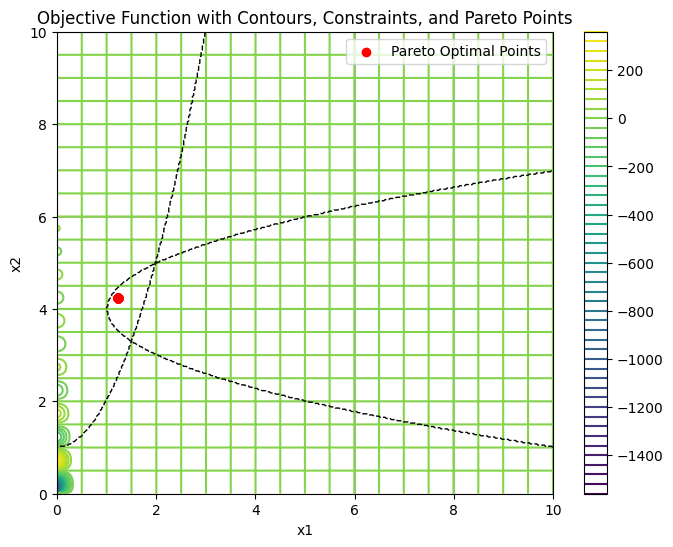

pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 0.0009585743233970767 0.0013877899583802922
pareto point: 

pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point: 2.3327118091890844 3.1622205838077515
pareto point

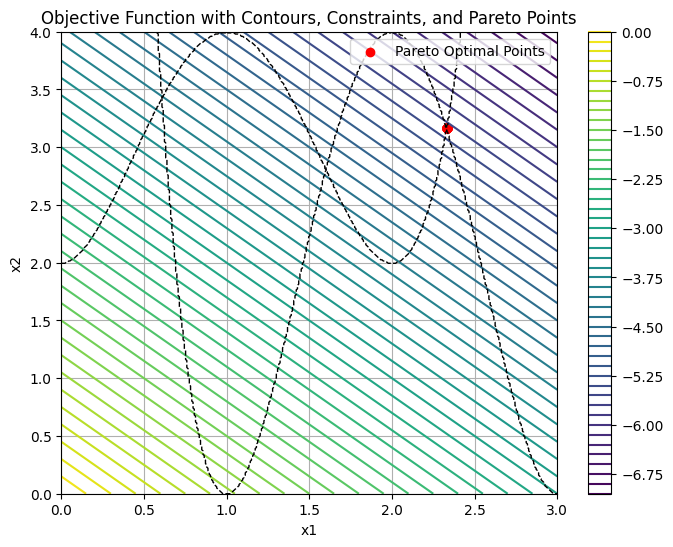

In [309]:
visualize_objective_with_constraints_and_pareto('resources/g6.txt', (13, 100), (0, 100), nsga2,  100, 200)

visualize_objective_with_constraints_and_pareto('resources/g8.txt', (0, 10), (0, 10), nsga2, 100, 200)

visualize_objective_with_constraints_and_pareto('resources/g11.txt', (-1, 1), (-1, 1), nsga2,  100, 200)

visualize_objective_with_constraints_and_pareto('resources/g24.txt', (0, 3), (0, 4), nsga2, 100, 200)

C:\Users\Filip\AppData\Local\Temp\ipykernel_25972\1493059158.py:41: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, C, levels=0, colors='black', linestyles='dashed', linewidths=1)


pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314458964
pareto point: 13.022727879435372 0.04776681314

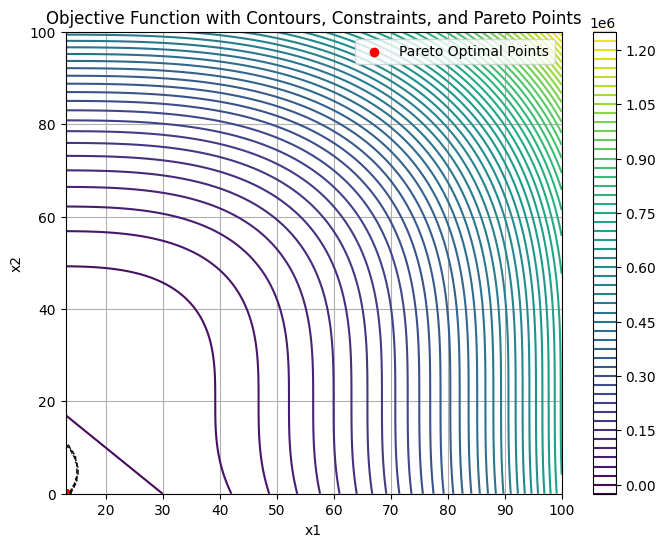

pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.2317798666032087 4.238307252648632
pareto point: 1.231779866603208

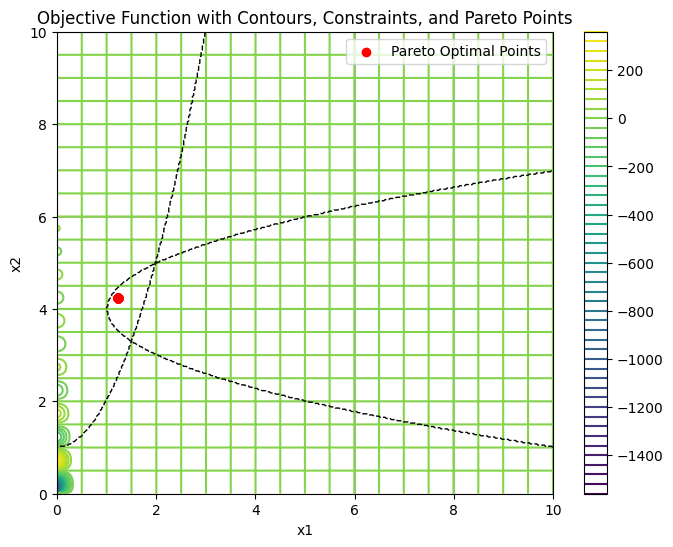

pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point: 0.9950970890580759 0.9916831763412166
pareto point

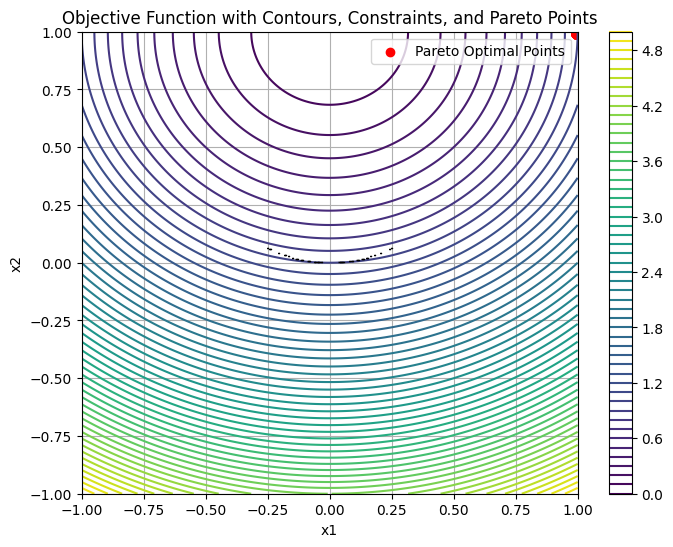

pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685
pareto point: 2.42481334648329 2.6856917151864685


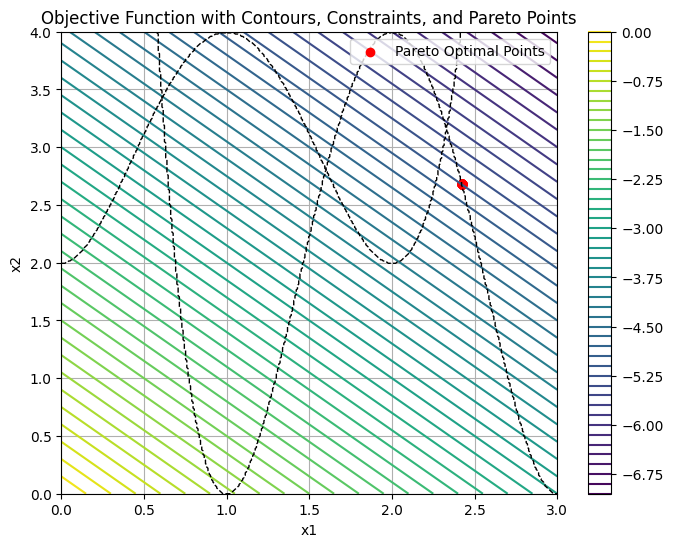

In [310]:
visualize_objective_with_constraints_and_pareto('resources/g6.txt', (13, 100), (0, 100), stochastic_ranking,  100, 200)

visualize_objective_with_constraints_and_pareto('resources/g8.txt', (0, 10), (0, 10), stochastic_ranking, 100, 200)

visualize_objective_with_constraints_and_pareto('resources/g11.txt', (-1, 1), (-1, 1), stochastic_ranking,  100, 200)

visualize_objective_with_constraints_and_pareto('resources/g24.txt', (0, 3), (0, 4), stochastic_ranking, 100, 200)

### Repeated testing ###
To determine algorithms' general behaviour for multiple problems.

In [311]:
results = test_algorithm_multiple_times('resources/g6.txt', stochastic_ranking, 100, 100, 2)
print(results)

results = test_algorithm_multiple_times('resources/g8.txt', stochastic_ranking, 100, 100, 2)
print(results)

results = test_algorithm_multiple_times('resources/g11.txt', stochastic_ranking, 100, 100, 2)
print(results)

results = test_algorithm_multiple_times('resources/g24.txt', stochastic_ranking, 100, 100, 2)
print(results)



results = test_algorithm_multiple_times('resources/g6.txt', nsga2, 100, 100, 2)
print(results)

results = test_algorithm_multiple_times('resources/g8.txt', nsga2, 100, 100, 2)
print(results)

results = test_algorithm_multiple_times('resources/g11.txt', nsga2, 100, 100, 2)
print(results)

results = test_algorithm_multiple_times('resources/g24.txt', nsga2, 100, 100, 2)
print(results)


{'average_time': 0.532257080078125, 'average_fitness': -1518.1241898023493, 'best_fitness': -1544.7861043940377, 'all_pareto_fronts': [[[4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.005684400661793432], [4.941123724544472e-05, 0.03575943076962418], [4.941123724544472e-05, 0.03575943076962418], [4.941123724544472e-05, 0.03575943076962418], [4.941123724544472e-05, 0.03575943076962418], [4.941123724544472e-05, 0.03575943076962418], [4.941123724544472e-05, 0.03575943076962418], [4.941123724544472e-05, 

KeyboardInterrupt: 